# Shoot and Go (SG) at Emails data 
# (ten departments)

Since it seems that the Shoot and Go is the best for the task of optimal parameters searching, it was decided to try it on more complex data, such as the emails data set.

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/emails/ten_edges.csv',
            '../data/emails/ten_labels.csv')

In [4]:
default_params=[1., 10, 80, 10]

In [5]:
# performance criteria
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

## Experiment run

### Shoot and go

In [6]:
from heur_sg import ShootAndGo
NUM_RUNS = 10
maxeval = 10

In [7]:
def experiment_SG(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_' + str(hmax) + '.csv')
    
    return res

In [8]:
sg_table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
    res = experiment_SG(n2v, maxeval, hmax, default_params)
    sg_table = pd.concat([sg_table, res], axis=0)

In [9]:
sg_table.groupby(['hmax'])['best_y'].median()

hmax
0.0     0.743570
1.0     0.742394
2.0     0.742078
5.0     0.741914
10.0    0.738578
20.0    0.738218
50.0    0.737922
inf     0.739401
Name: best_y, dtype: float64

In [10]:
sg_table.groupby(['hmax'])['best_y'].mean()

hmax
0.0     0.743847
1.0     0.743006
2.0     0.739830
5.0     0.741678
10.0    0.740032
20.0    0.737214
50.0    0.738600
inf     0.739028
Name: best_y, dtype: float64

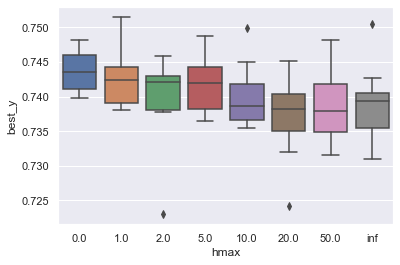

In [11]:
ax = sns.boxplot(x="hmax", y="best_y", data=sg_table)

In [43]:
sg_table.sort_values(by=['best_y'], ascending=False).head(5)

,heur,run,hmax,best_x,best_y,neval
6,SG_1,6,1.0,"[1.7214178926743262, 1.0, 10, 80, 10]",0.751544,inf
2,SG_inf,2,inf,"[1.8283190310266115, 1.0, 10, 80, 10]",0.750439,inf
6,SG_10,6,10.0,"[3.476639162720879, 1.0, 10, 80, 10]",0.749871,inf
4,SG_1,4,1.0,"[1.8492925253591181, 1.0, 10, 80, 10]",0.749847,inf
2,SG_5,2,5.0,"[1.778306855029617, 1.0, 10, 80, 10]",0.748814,inf


FEO

In [12]:
results_pivot_sg = sg_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot_sg = results_pivot_sg.reset_index()
results_pivot_sg.sort_values(by='hmax')

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,heur,hmax,rel
0,SG_0,0.0,0.0
1,SG_1,1.0,0.0
3,SG_2,2.0,0.0
5,SG_5,5.0,0.0
2,SG_10,10.0,0.0
4,SG_20,20.0,0.0
6,SG_50,50.0,0.0
7,SG_inf,inf,0.0


## Conclusion

- The best value Rand index value equaled to $0.49$ without the use of heuristic. 
- Clearly, with the help of heuristics the improvement of the result was managed. The Rand index score equals $0.75$ now. 